In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()

In [2]:
sparse_predictors = ["age_group", "male", "anc_cat", "facdelivery", "hh_urban", "v024"] #administrative data
contextual_predictors = ["nightlights_composite", "un_population_cat", "travel_times_2015"] #custer level data from censor
additional_predictors = ["birth_order", "mum_educlow", "mum_educhigher",
                        "npregnancies", "firstpreg", "hh_5plus", "hh_wealth"]# survey data
                       

contextual_datasets = ['IA2020', 'IA2015','ML2018','NG2018']

In [3]:
#Utility functions
categorical_predictors = ['age_group', 'anc_cat', 'un_population_cat', 'nightlights_composite', 'v024', 'clusterid', 'hh_wealth']
extra_features = ['sdist', 'regionname', 'clusterid', 'all_vac', 'ia2015fic', 'IMI_target']

#Read file from CSV and return a dataframe
def read_file(country, verbose = False):
    df = (pd.read_csv('../data/clean_data/' + country + ".csv"))
    for feature in categorical_predictors:
        if feature in df.columns:
            df[feature] = df[feature].astype('category')
    if verbose:
        print('Read complete: Clean data for '+country)
        print(df.dtypes)
    return df

def get_clean_dataset(country, verbose = False):
    df = read_file(country, verbose)
    if country =='IA2020':
        df = df.drop(['sdist', 'regionname', 'clusterid', 'all_vac'], axis=1)
    elif country == 'IA2015':        
        df = df.drop(extra_features, axis=1)
    else:
        df = df.drop(['regionname', 'clusterid', 'all_vac'], axis=1)
    
    df = df.dropna()
    if(verbose):
        print("Missing values and extra columns removed.")
    return df

In [4]:
#Dataset structure for a particular country
country = 'IA2015'
d = get_clean_dataset(country)
d.dtypes

any_vac                     int64
age_group                category
male                        int64
anc_cat                  category
facdelivery                 int64
hh_urban                    int64
v024                     category
birth_order                 int64
mum_educlow                 int64
mum_educhigher              int64
npregnancies                int64
firstpreg                   int64
hh_5plus                    int64
hh_wealth                category
nightlights_composite    category
un_population_cat        category
travel_times_2015         float64
dtype: object

In [5]:
#List of countries 
countries = ['IA2020', 'IA2015', 'IA2006', 'ML2018', 'ML2006', 'NG2018', 'NG2008']

#List of modes: 
modes = ['sparse', 'sparse+contextual', 'all']

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

def get_data(country, verbose = False):
    X = get_clean_dataset(country, verbose)
    if verbose:
        print('Dimension of the complete data: '+X.shape) 
    return(X)

def encode_dataset(X, verbose = False):
    for i in range (X.shape[1]):
        le = LabelEncoder()
        X[X.columns[i]] = le.fit_transform(X.values[:,i])
    if verbose:
        print('Encoded dataset X')
        print('X.head='+X.head)
    return (X)

def encode_array(y, verbose = False):
    le = LabelEncoder()
    y = le.fit_transform(y)
    if verbose:
        print('Encoded array y')
        print ('y='+y)
    return (y)

def create_train_test_split(country, mode, ts=0.3):
    #country is one of ["ML2018", "NG2018", "ML2006", "IA2006",  "NG2008", "IA2015", "IA2020"]
    #mode is one of ['sparse', 'sparse+contextual', 'all']
    #randomly select test_size% of data from each state to create the test dataset; make everything else training set
    D = get_data(country)
    #print(D.columns)
    if mode == 'sparse':
        if country in ['IA2020', 'IA2015', 'ML2018', 'NG2018']:
            D =  D.drop(contextual_predictors+additional_predictors, axis=1)
        else:
            D =  D.drop(additional_predictors, axis=1)
    elif mode == 'sparse+contextual':
        D =  D.drop(additional_predictors, axis=1)    
    D = D.dropna()
    region = D['v024']
    #print(D.dtypes)
    D = pd.get_dummies(data=D, drop_first=True)
    D_train = pd.DataFrame(np.empty(0, dtype=D.dtypes))
    D_test = pd.DataFrame(np.empty(0, dtype=D.dtypes))

    for state in (region.unique()):
        X = D[region==state]
        y = X['any_vac']
        X = X.drop(['any_vac'], axis = 1)  
        X = encode_dataset(X)
        y = encode_array(y) 

        X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=65, test_size=ts)    
        #X_train['v024'] = np.array([state]*X_train.shape[0])
        X_train['any_vac'] = y_train
        #X_test['v024'] = np.array([state]*X_test.shape[0])
        X_test['any_vac'] = y_test

        D_train = pd.concat([D_train, X_train])
        D_test = pd.concat([D_test,X_test])

    D_train = D_train.sample(frac=1)
    D_test = D_test.sample(frac=1)

    X_tr = D_train.drop(['any_vac', 0], axis=1)
    y_tr = D_train['any_vac']

    X_tst = D_test.drop(['any_vac', 0], axis=1)
    y_tst = D_test['any_vac']

    return (X_tr, X_tst, y_tr, y_tst)    

In [11]:
from math import sqrt
from sklearn import linear_model as lm
from sklearn import neural_network as nn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
import math
import xgboost
import statistics
import statsmodels.api as sm
import sklearn.tree as tree
import re
from sklearn.neighbors import KNeighborsClassifier


SVC_params = {'kernel': ['linear', 'rbf'],
              'C': [0.1, 1, 10]}

ridge_params = {'alpha': np.logspace(-8, -1, 1, 2)}
lasso_params = {'alpha': np.logspace(-1, 1, 2)}
logistic_params = {'C': [0.1, 1], 
                   'penalty': ['l2'], 
                   'max_iter' : [1000]}
MLP_params = {
    'alpha': [0.0001, .1, 0.05]
}
SGD_params = {'alpha': np.logspace(-4, 4, 5)}
XGBoost_params = {'sampling_method': ['uniform', 'gradient_based']}
adaboost_params = {'n_estimators' : [10, 50, 100, 500, 1000]}
decisiontree_params = {'criterion' : ['gini', 'entropy']}
NN_params = {'n_neighbors' : [2,3,8]}
forest_params = {'n_estimators':[100, 200]}


# Three sets: regular algorithms, class-sensitive algorithms, then try the regular 
classification_models = [["Ridge",lm.RidgeClassifier(random_state=0), ridge_params],
                         #["Lasso", lm.Lasso(), lasso_params],
                         #["SVC", svm.SVC(), SVC_params], 
                         #["Logistic Regression", lm.LogisticRegression(random_state = 0, solver = 'lbfgs'), logistic_params], 
                         #["SGD", lm.SGDClassifier(), SGD_params],                         
                         ["Decision Tree", DecisionTreeClassifier(random_state=0),decisiontree_params],
                         ["Nearest Neighbor", KNeighborsClassifier(), NN_params],
                         ["MLP", MLPClassifier(random_state=0, max_iter=300), MLP_params]
                         #["XGB", XGBClassifier(), XGBoost_params],
                         #["AdaBoost",AdaBoostClassifier(n_estimators=100, random_state=0), adaboost_params],
                         ]
 
cost_sensitive_models = [#["Cost-sensitive SVC", svm.SVC(class_weight="balanced"), SVC_params], 
                         ["Cost-sensitive Ridge", lm.RidgeClassifier(random_state=0,class_weight = "balanced"), ridge_params],
                         #["Cost-sensitive Lasso", lm.Lasso(), lasso_params],
                         #["Cost-sensitive Logistic",lm.LogisticRegression(class_weight="balanced"),logistic_params],                         
                         #["Cost-sensitive SGD",lm.SGDClassifier(class_weight = "balanced"),SGD_params],
                         #["Cost-sensitive XGB",XGBClassifier(), XGBoost_params],
                         ["Cost-sensitive Decision Tree", tree.DecisionTreeClassifier(random_state=0,class_weight = "balanced"),decisiontree_params],
                         ["Cost-sensitive Nearest Neighbor", KNeighborsClassifier(), NN_params],                         
                         ["Cost-sensitive MLP", MLPClassifier(random_state=0, max_iter=300), MLP_params]]
                        

def specificity_scorer(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    specificity = (tn / (tn + fp))

    return specificity

def sensitivity_scorer(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = (tp / (tp + fn))
    
 
    return sensitivity

met_grid= {'roc_auc': 'roc_auc', 'accuracy':'accuracy', 'f1': 'f1', 
           'sensitivity': make_scorer(sensitivity_scorer), 'specificity': make_scorer(specificity_scorer)} #The metric codes from sklearn
        

In [30]:
#Increase cost-sensitive weights and observe the model's behavior (Using Ridge Classifier)

def graph_metrics_versus_weight(country, amt_points):
    plt.figure(figsize=(15,12))
    plt.rcParams.update({'font.size': 28})
    accuracy_scores = []  
    specificity_scores = []
    sensitivity_scores = []
    f1_scores = []
    df = read_file(country)
    X= get_clean_dataset(country)
    y=X['any_vac']
    X = X.drop('any_vac', axis=1)
    #X['v024'] = X['v024'].astype('category')
    X = pd.get_dummies(data=X, drop_first=True)
    print(X.values[X.isna()])
    column_names = X.columns
    X = encode_dataset(X)
    y = encode_array(y) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=26, test_size = 0.3)

       
    zero_weights = np.arange(1,amt_points/2)
    zero_weights = 0.5 + (zero_weights /amt_points)
   
    for i in zero_weights:
    #     Hyperparams that do best with this dataset 
        model = lm.RidgeClassifier(random_state=0, alpha = 0.00000001, class_weight = {0:i, 1:1-i})


        model.fit(X_train,y_train)

    #         Now, let's see how the model does on the test data

        ypred = model.predict(X_test)


        accuracy = accuracy_score(y_test, ypred)
        tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()
        sensitivity = (tp / (tp + fn))
        specificity = (tn / (tn + fp))
        f1score = f1_score(y_test, ypred)
        f1_scores.append(f1score)
        accuracy_scores.append(accuracy)
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)
    frac_ratio = np.mean(y_train)
    plt.title('Comparison of Ridge Regression performance with increase in penalty on misclassifying ZD a child ('+country+')')
    plt.xlabel('Proportional cost')
    #plt.ylabel('Metric Value')
    plt.style.use('_mpl-gallery')
    plt.plot(zero_weights , sensitivity_scores, label = "sensitivity")
    plt.plot(zero_weights, specificity_scores, label = "specificity")
    #plt.plot(zero_weights, accuracy_scores, label = "accuracy")    
    plt.plot(zero_weights, f1_scores, label = "F1 score", color = "purple")
    plt.axvline(x = frac_ratio, color = 'black', ls='--', label = 'fraction of non-ZD children')
    plt.legend()
    plt.savefig('../results/Model_outcomes/changing_penalty_'+country+'.png', format = 'png', dpi=600, bbox_inches='tight')  
    plt.show()


[]


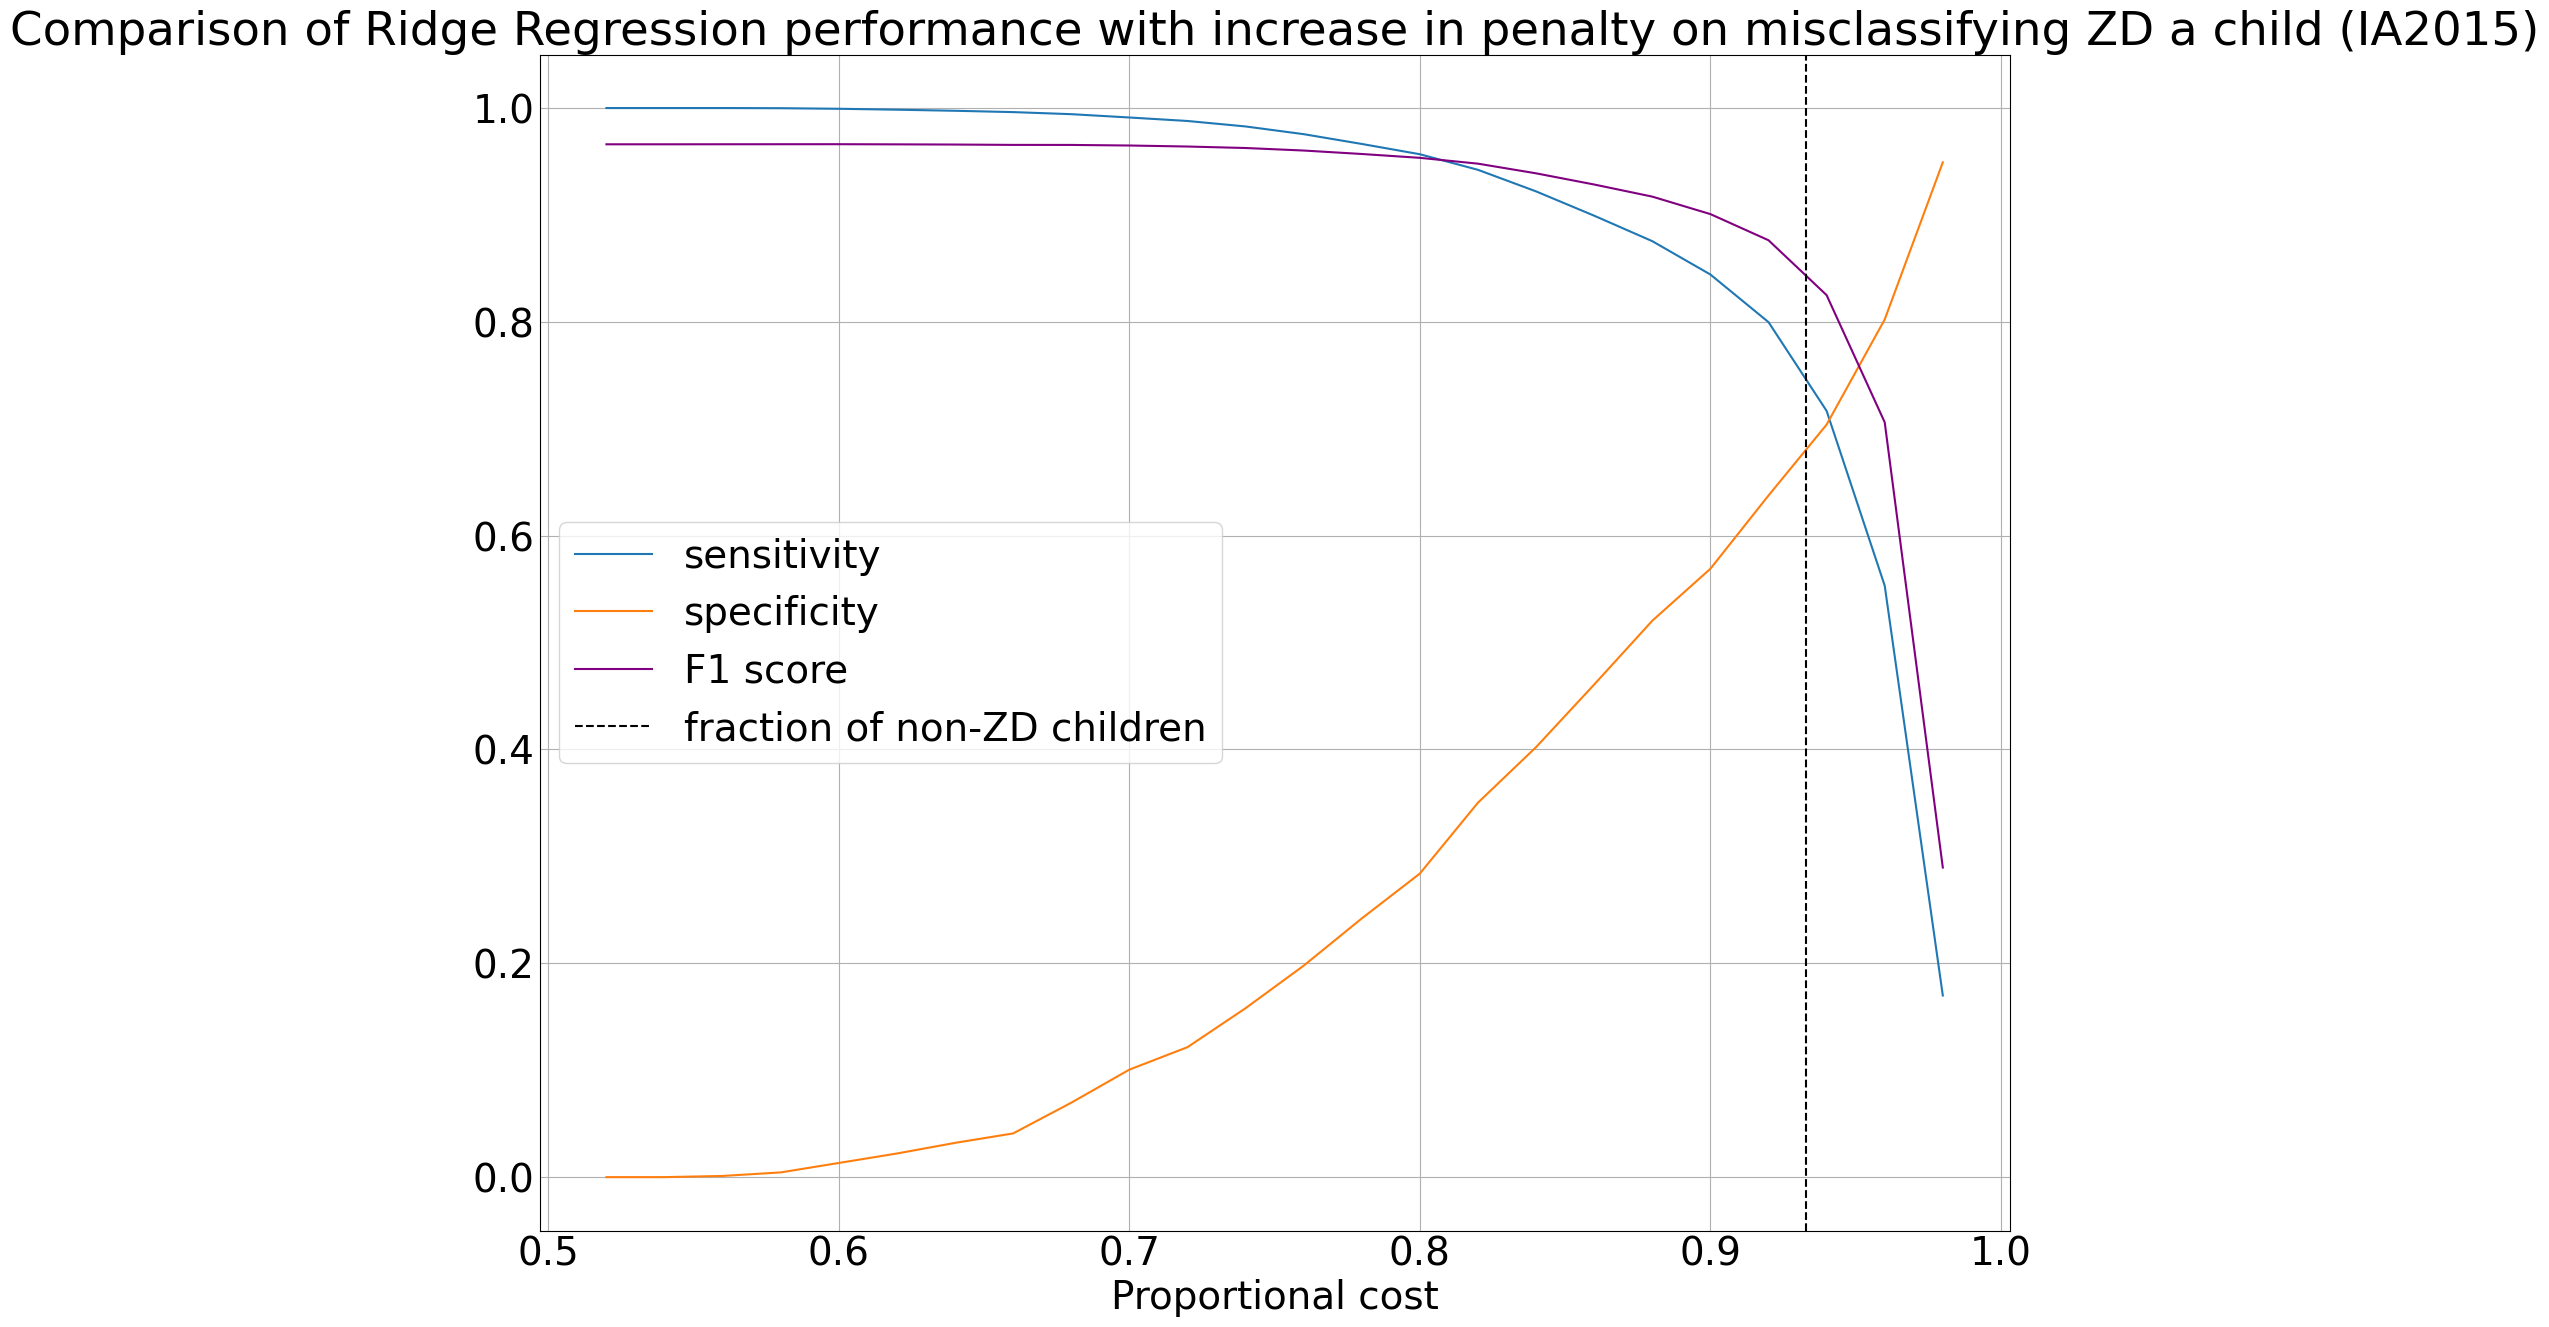

In [31]:
graph_metrics_versus_weight('IA2015', 50)

In [48]:
import os.path
from os import path

filename = '../results/Model_outcomes/new_all_results_expanded_testsize_diff_cost'
def run_models(country, modes, models, refit, test_size): 
    #print(models)   
    #Create train and test datasets
    for mode in modes:
        if (country in ['IA2006', 'ML2006', 'NG2008']) and (mode == 'sparse+contextual'):
            continue
        print( 'Mode: '+mode)

        model_scores = []
        if (path.exists(filename+str(test_size)+'.csv')):
            print ('Result file exists: reading copying existing results')
            model_scores = pd.read_csv(filename+str(test_size)+'.csv')
        else:
            model_scores = pd.DataFrame(columns=["country", "mode", "model", "mean_train_f1", "mean_train_accuracy",
                    "mean_train_roc_auc", "mean_train_specificity", "mean_train_sensitivity", "tp", "tn", "fp", "fn",
                        "roc", "sensitivity", "specificity", "f1", "accuracy", "best_params", "is_SMOTE", "refit"])           
        
        X_train, X_test, y_train, y_test = create_train_test_split(country, mode, ts=test_size)
        
        for model in models:        
            print('Country: '+country+',Model: '+model[0]+', Mode: '+mode)           
                      
            if model[0] in ["Cost-sensitive MLP", "Cost-sensitive Nearest Neighbor"]:
                model[1].scale_pos_weight = sum(y_train) / (len(y_train.index) - sum(y_train))
            if model[0] in ["Cost-sensitive Ridge", "Cost-sensitive SGD"]:
                w = np.mean(y_train)
                model[1] = lm.RidgeClassifier(class_weight = {0:w, 1:1-w}, random_state=0)
    

            grid = GridSearchCV(estimator=model[1], param_grid=model[2],scoring=met_grid,refit=refit) 
            
            grid.fit(X_train,y_train)
            
            
            mean_train_f1 = grid.cv_results_['mean_test_f1'][grid.best_index_]
            mean_train_accuracy = grid.cv_results_['mean_test_accuracy'][grid.best_index_]
            mean_train_roc_auc = grid.cv_results_['mean_test_roc_auc'][grid.best_index_]
            mean_train_specificity = grid.cv_results_['mean_test_specificity'][grid.best_index_]
            mean_train_sensitivity = grid.cv_results_['mean_test_sensitivity'][grid.best_index_]
        
            #Evaluate on test data

            grid_predictions = grid.predict(X_test)

            roc = roc_auc_score(y_test.to_list(), grid_predictions)
            accuracy = accuracy_score(y_test, grid_predictions)
            tn, fp, fn, tp = confusion_matrix(y_test, grid_predictions).ravel()
            sensitivity = (tp / (tp + fn))
            specificity = (tn / (tn + fp))
            f1 = f1_score(y_test, grid_predictions)
            
            results = {"country": country, "mode":mode, "model": model[0], "mean_train_f1": mean_train_f1, "mean_train_accuracy": mean_train_accuracy,
                    "mean_train_roc_auc":mean_train_roc_auc, "mean_train_specificity":mean_train_specificity,
                    "mean_train_sensitivity":mean_train_sensitivity,
                    "roc": roc , "tp":tp, "tn":tn, "fp":fp, "fn":fn, "sensitivity" : sensitivity,
                    "specificity": specificity, "f1":f1, "accuracy": accuracy, "best_params":str(grid.best_params_), "is_SMOTE": "no", "refit": refit}
            print(results)
            results_df = pd.DataFrame([results])
            model_scores = pd.concat([model_scores, results_df], ignore_index = True)
        
        model_scores.to_csv(filename+str(test_size)+'.csv', index=False)
    return model_scores


In [ ]:
countries = ['IA2020', 'IA2015', 'IA2006', 'ML2018', 'ML2006', 'NG2018', 'NG2008']
modes = ['sparse', 'sparse+contextual', 'all']
for country in countries:
    scores_non_cost_sensitive = run_models(country, modes, classification_models, "accuracy", test_size=0.3)
for country in countries:
    scores_cost_sensitive = run_models(country, modes, cost_sensitive_models, "accuracy", test_size=0.3)


In [43]:
#train on old data and test on new data
def test_new_on_old (old_data='IA2015', new_data='IA2020', mode='all', test_size=0.3):
    model_scores = []
    if (path.exists('../results/Model_outcomes/old_new_Jan23'+str(test_size)+'.csv')):
        print ('Result file exists: reading copying existing results')
        model_scores = pd.read_csv('../results/Model_outcomes/old_new_Jan23'+str(test_size)+'.csv')
    else:
        model_scores = pd.DataFrame(columns=["old_country", "new_country", "mode", "tp", "tn", "fp", "fn",
                    "roc", "sensitivity", "specificity", "f1", "accuracy"])
    D_new = get_data(new_data)
    D_old = get_data(old_data) 
    
    if old_data =='IA2015':
        if mode == 'sparse':
            D_old = D_old.drop(contextual_predictors+additional_predictors, axis=1)
            D_new = D_new.drop(contextual_predictors+additional_predictors, axis=1)
        elif mode == 'sparse+contextual':
            D_old =  D_old.drop(additional_predictors, axis=1)
            D_new =  D_new.drop(additional_predictors, axis=1)
    else:
        if mode == 'sparse':
            D_old = D_old.drop(additional_predictors, axis=1)
            D_new = D_new.drop(additional_predictors+contextual_predictors, axis=1)
        else:
            D_new = D_new.drop(contextual_predictors, axis=1)

    D_old = pd.get_dummies(data=D_old, drop_first=True)
    D_new = pd.get_dummies(data=D_new, drop_first=True)
    old_cols = (D_old.columns)
    new_cols = (D_new.columns)
    common = np.array(set(old_cols).intersection(new_cols))
    print(common)
    D_old = D_old[common]
    D_new = D_new[common]

    X_train = D_old.drop('any_vac', axis=1)
    X_test = D_new.drop('any_vac', axis=1)
    y_train = D_old['any_vac']
    y_test = D_new['any_vac']

    X_train = encode_dataset(X_train)
    y_train = encode_array(y_train)

    X_test = encode_dataset(X_test)
    y_test = encode_array(y_test)

    r_classifier = lm.RidgeClassifier(class_weight = "balanced", alpha = 0.00000001)
    r_classifier.fit(X_train,y_train)
    predicted_y = r_classifier.predict(X_test)

    roc = roc_auc_score(y_test, predicted_y)
    accuracy = accuracy_score(y_test, predicted_y)
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_y).ravel()
    sensitivity = (tp / (tp + fn))
    specificity = (tn / (tn + fp))
    f1 = f1_score(y_test, predicted_y)

    results = {"old_country": old_data, "new_country": new_data,"mode":mode, "tp": tp, "tn":tn, "fp":fp, "fn":fn, "roc": roc , "sensitivity" : sensitivity,
            "specificity": specificity, "f1":f1, "accuracy": accuracy}
    results_df = pd.DataFrame([results])
    model_scores = pd.concat([model_scores, results_df], ignore_index = True)
        
    model_scores.to_csv('../results/Model_outcomes/old_new_Jan23'+str(test_size)+'.csv', index=False)
    print(results)

In [44]:
new_countries= ['IA2020', 'IA2020', 'ML2018', 'NG2018']
old_countries= ['IA2015', 'IA2006', 'ML2006', 'NG2008']

for i in [0,1,2,3]:
    if (i==0):
        test_new_on_old(old_data=old_countries[i], new_data=new_countries[i], mode='sparse')
        test_new_on_old(old_data=old_countries[i], new_data=new_countries[i], mode='sparse+contextual')
        test_new_on_old(old_data=old_countries[i], new_data=new_countries[i], mode='all')
    else:
        test_new_on_old(old_data=old_countries[i], new_data=new_countries[i], mode='sparse')
        test_new_on_old(old_data=old_countries[i], new_data=new_countries[i], mode='all')

{'v024_1012', 'age_group_21-24', 'v024_1015', 'v024_1008', 'v024_1019', 'v024_1033', 'v024_1011', 'v024_1017', 'v024_1013', 'any_vac', 'anc_cat_low', 'age_group_15-17', 'v024_1006', 'v024_1028', 'v024_1016', 'v024_1002', 'v024_1003', 'v024_1009', 'male', 'hh_urban', 'v024_1041', 'v024_1042', 'v024_1024', 'v024_1021', 'v024_1014', 'v024_1070', 'v024_1032', 'v024_1007', 'v024_1018', 'v024_1045', 'facdelivery', 'v024_1010', 'age_group_18-20', 'anc_cat_no', 'v024_1027', 'v024_1029', 'v024_1044', 'v024_1023'}
{'old_country': 'IA2015', 'new_country': 'IA2020', 'mode': 'sparse', 'tp': 32890, 'tn': 598, 'fp': 896, 'fn': 5906, 'roc': 0.6240177743658415, 'sensitivity': 0.8477678111145479, 'specificity': 0.4002677376171352, 'f1': 0.9062853048965308, 'accuracy': 0.8311739885827749}
Result file exists: reading copying existing results
{'v024_1012', 'age_group_21-24', 'v024_1015', 'nightlights_composite_third', 'nightlights_composite_fourth', 'v024_1008', 'v024_1019', 'nightlights_composite_fifth', 